# Human Resource Analytics

### Names: Eli Kaustinen and Gabriel Marcelino

## Problem Statement
This analysis aims to identify the most important predictors of employee performance from a set of 35 indicators in the IBM HR Analytics Employee Attrition & Performance dataset. The goal is to guide company policies for awarding bonuses and requiring professional development by understanding which factors most significantly influence employee performance.

We will use Principal Component Analysis (PCA) to reduce dimensionality and identify the key variables that explain the majority of variance in employee performance. This will help the company focus on the most impactful factors when making decisions about rewards and professional development.

## Algorithm of the Solution

1. Define performance and performance predictors in the context of this dataset
2. Load necessary packages
3. Explore and prepare the data
4. Verify PCA assumptions:
   - Sphericity (Bartlett's Test)
   - Sample adequacy (Kaiser-Meyer-Olkin Test)
   - Positive determinant of correlation matrix
5. Perform PCA:
   - Determine optimal number of components
   - Analyze eigenvalues and variance explained
   - Create and interpret scree plot
   - Analyze component loadings
6. Calculate performance scores based on PCA weights
7. Analyze and interpret results


## Import Libraries and Load/Explore Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import scipy.stats as stats
from sklearn.metrics import silhouette_score
import warnings

# Load data 
df = pd.read_csv('data.csv')
df = df.dropna()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset information:")
print(df.info())

print("\nCategorical variables and their unique values:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")


Dataset shape: (1470, 35)

First 5 rows of the dataset:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  Relationsh

## Potential Variables related to Performance

In [4]:
performance_cols = [
    'JobSatisfaction', 
    'PerformanceRating', 
    'WorkLifeBalance', 
    'EnvironmentSatisfaction', 
    'JobInvolvement'
]

# Identify potential predictors
predictor_cols = [col for col in df.columns if col not in performance_cols and col not in ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18']]

# Display counts of attrition
print("\nAttrition distribution:")
print(df['Attrition'].value_counts())
print(f"Attrition rate: {df['Attrition'].value_counts(normalize=True)['Yes']*100:.2f}%")



Attrition distribution:
Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition rate: 16.12%


## Prepare Data

In [5]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Remove non-informative columns
cols_to_drop = ['EmployeeNumber', 'EmployeeCount', 'StandardHours']
df_encoded = df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns])

# Display the resulting dataset
print(f"\nEncoded dataset shape: {df_encoded.shape}")
print(df_encoded.head())

# Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_encoded),
    columns=df_encoded.columns
)

print("\nStandardized data (first 5 rows):")
print(df_scaled.head())


Encoded dataset shape: (1470, 45)
   Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0   41       1102                 1          2                        2   
1   49        279                 8          1                        3   
2   37       1373                 2          2                        4   
3   33       1392                 3          4                        4   
4   27        591                 2          1                        1   

   HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  ...  \
0          94               3         2                4           5993  ...   
1          61               2         2                2           5130  ...   
2          92               2         1                3           2090  ...   
3          56               3         1                3           2909  ...   
4          40               3         1                2           3468  ...   

   JobRole_Laboratory Technician 

## Correlation Matrix

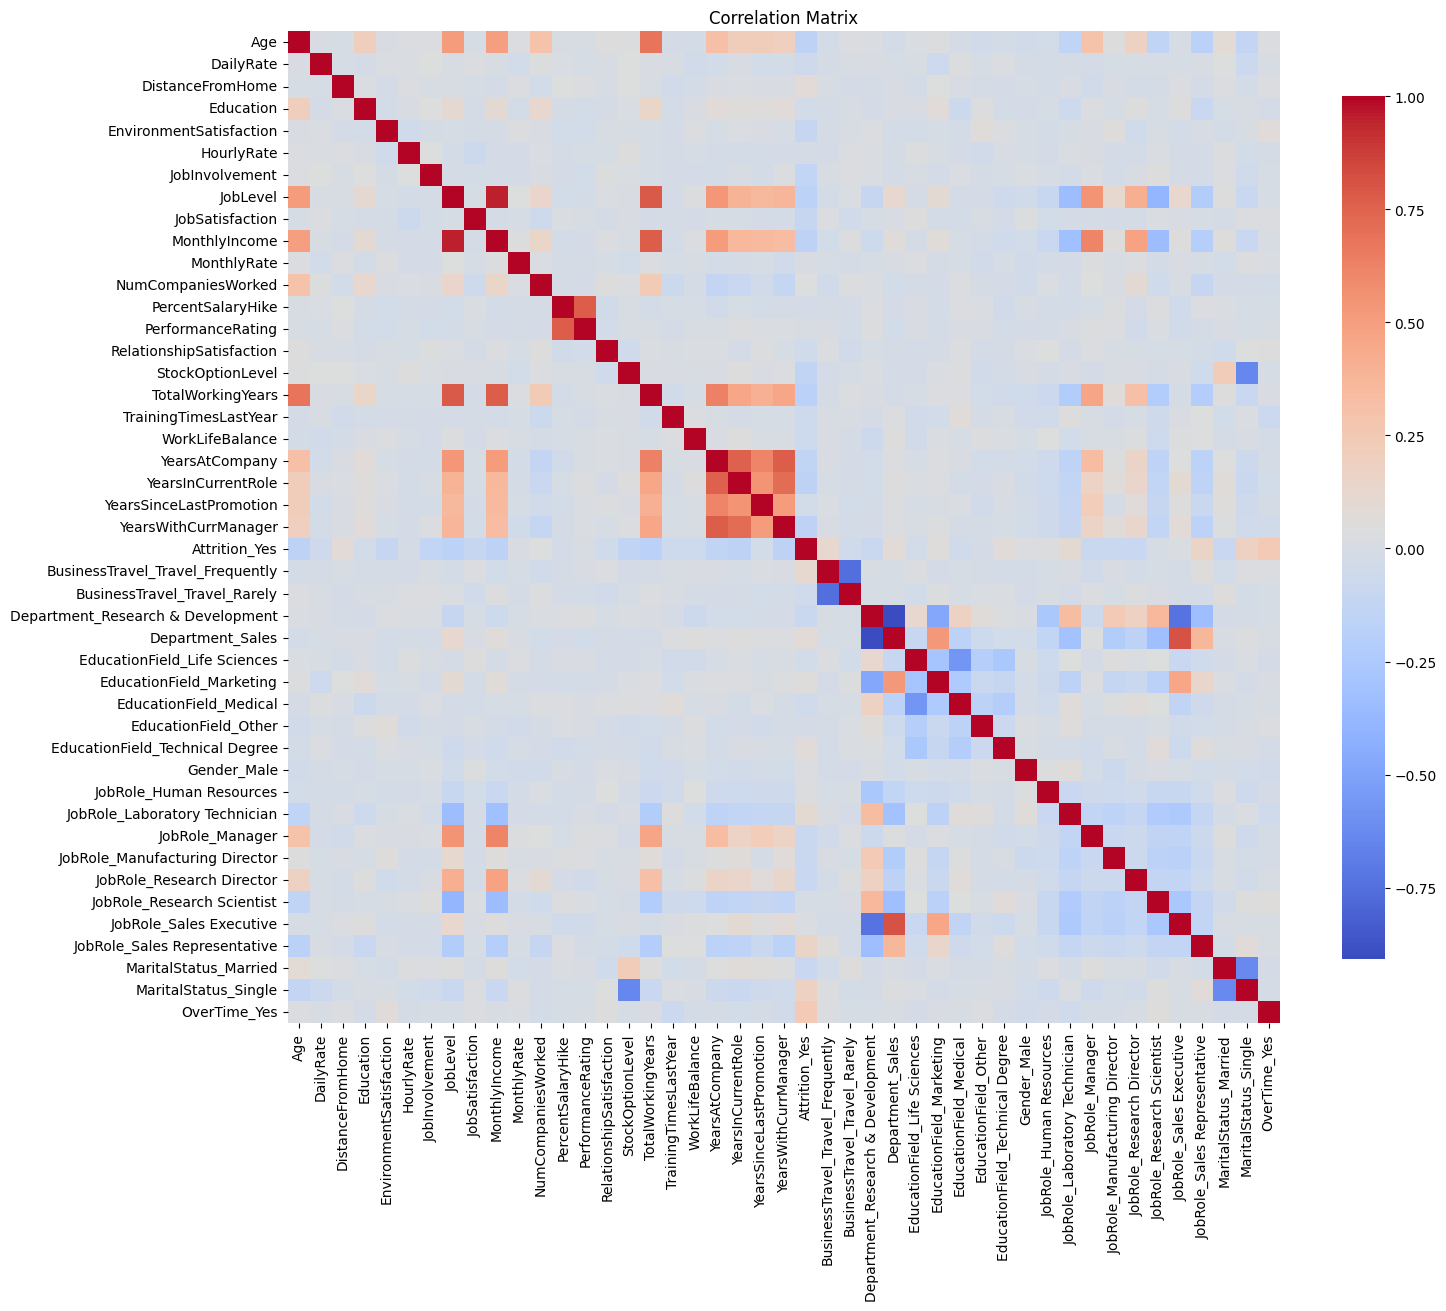

In [6]:
# Compute correlation matrix
corr_matrix = df_scaled.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


## Compute the variance-covariance matrix

In [7]:
# Compute the variance-covariance matrix
cov_matrix = df_scaled.cov()

# Display summary statistics of the covariance matrix
print("\nCovariance matrix shape:", cov_matrix.shape)
print("\nCovariance matrix summary statistics:")
print("Min value:", cov_matrix.min().min())
print("Max value:", cov_matrix.max().max())
print("Mean value:", cov_matrix.mean().mean())


Covariance matrix shape: (45, 45)

Covariance matrix summary statistics:
Min value: -0.9074355569581819
Max value: 1.0006807351940177
Mean value: 0.02852783802453004


## Check Statistical Significance of Bivariate Correlations

C:\Users\Busters\AppData\Local\Temp\ipykernel_7272\2896952431.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = stats.pearsonr(df[r], df[c])[1]



Number of statistically significant correlations: 262.0 out of 990.0 pairs (26.46%)


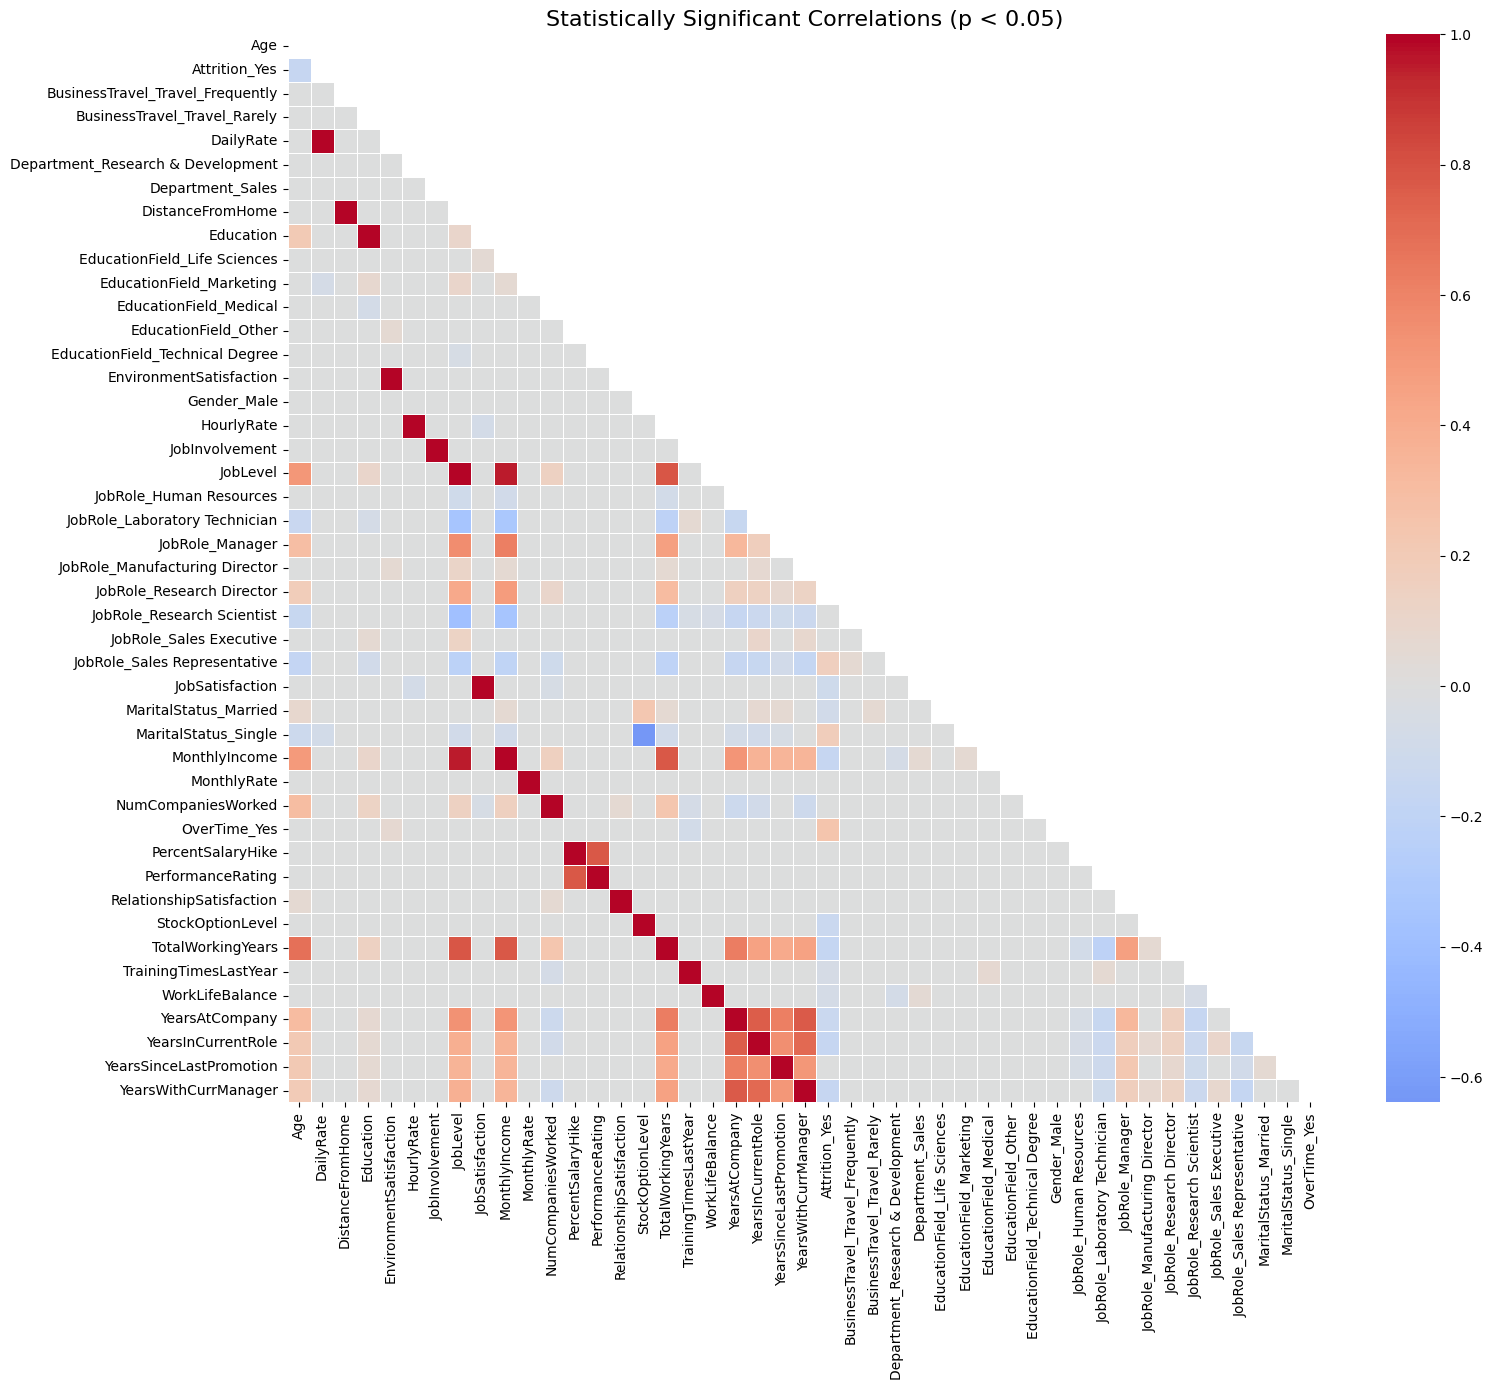

In [8]:
# Function to calculate p-values for correlation matrix
def calculate_pvalues(df):
    df = df.dropna()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = stats.pearsonr(df[r], df[c])[1]
            
    return pvalues

# Calculate p-values for correlation matrix
p_values = calculate_pvalues(df_scaled)

# Create a mask for statistically significant correlations (p < 0.05)
mask = p_values < 0.05
significant_corr = corr_matrix * mask

# Count significant correlations
num_significant = (mask.sum().sum() - mask.shape[0]) / 2  # Subtract diagonal and divide by 2 (symmetric)
total_pairs = (mask.shape[0] * (mask.shape[0] - 1)) / 2
significant_percentage = (num_significant / total_pairs) * 100

print(f"\nNumber of statistically significant correlations: {num_significant} out of {total_pairs} pairs ({significant_percentage:.2f}%)")

# Plot the significant correlations
plt.figure(figsize=(16, 14))
mask_upper = np.triu(np.ones_like(significant_corr, dtype=bool))
sns.heatmap(significant_corr, mask=mask_upper, annot=False, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Statistically Significant Correlations (p < 0.05)', fontsize=16)
plt.tight_layout()
plt.savefig('significant_correlations.png', dpi=300)
plt.show()

## Verify PCA Assumptions

### 1. Sphericity (Bartlett Test)


In [9]:
# Perform Bartlett's test of sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
print("\nBartlett's test of sphericity:")
print(f"Chi-square value: {chi_square_value:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"Interpretation: {'Suitable for PCA' if p_value < 0.05 else 'Not suitable for PCA'}")


Bartlett's test of sphericity:
Chi-square value: 35171.9580
p-value: 0.0000000000
Interpretation: Suitable for PCA


### 2. Sample Adequacy (Kaiser-Meyer-Olkin test)

In [10]:
# Perform Kaiser-Meyer-Olkin test
kmo_all, kmo_model = calculate_kmo(df_scaled)
print("\nKaiser-Meyer-Olkin (KMO) test:")
print(f"KMO value: {kmo_model:.4f}")
print(f"Interpretation: {'Acceptable' if kmo_model > 0.5 else 'Not acceptable'}")


Kaiser-Meyer-Olkin (KMO) test:
KMO value: 0.4868
Interpretation: Not acceptable


c:\Users\Busters\Documents\GitHub\CST-425\.venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


### 3. Positive Determinant of the Matrix

In [11]:
# Calculate determinant of correlation matrix
determinant = np.linalg.det(corr_matrix)
print(f"\nDeterminant of correlation matrix: {determinant:.10e}")
print(f"Is the determinant positive? {'Yes' if determinant > 0 else 'No'}")
print(f"Is the matrix singular? {'Yes' if abs(determinant) < 1e-10 else 'No'}")


Determinant of correlation matrix: 3.0795141916e-11
Is the determinant positive? Yes
Is the matrix singular? Yes


## PCA Analysis


PCA Results:
Total number of components: 45
Number of components explaining 85% of variance: 26

Explained variance by component:
   Component  Eigenvalue  Explained Variance (%)  Cumulative Variance (%)
0          1    5.387716               11.964558                11.964558
1          2    3.475943                7.719063                19.683621
2          3    2.111114                4.688173                24.371794
3          4    1.992289                4.424297                28.796091
4          5    1.788518                3.971780                32.767871
5          6    1.725569                3.831990                36.599861
6          7    1.610100                3.575567                40.175428
7          8    1.353996                3.006833                43.182260
8          9    1.322796                2.937546                46.119807
9         10    1.300466                2.887958                49.007765


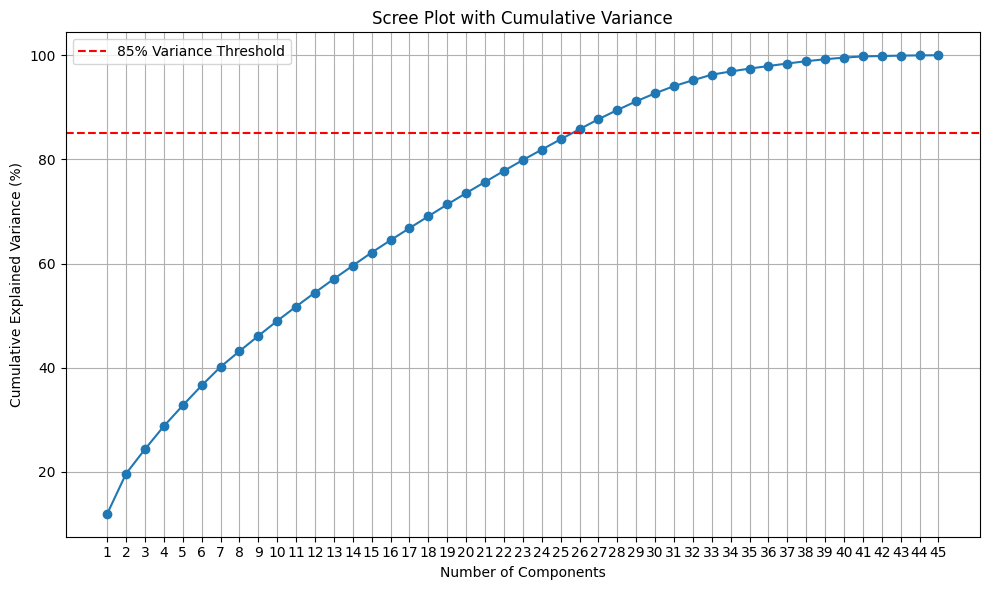

In [12]:
# Initialize PCA 
pca_full = PCA()
pca_full.fit(df_scaled)

# Calculate explained variance ratio
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components that explain at least 85% of variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print("\nPCA Results:")
print(f"Total number of components: {len(explained_variance)}")
print(f"Number of components explaining 85% of variance: {n_components_85}")

# Display explained variance for each component
variance_df = pd.DataFrame({
    'Component': range(1, len(explained_variance) + 1),
    'Eigenvalue': pca_full.explained_variance_,
    'Explained Variance (%)': explained_variance * 100,
    'Cumulative Variance (%)': cumulative_variance * 100
})

print("\nExplained variance by component:")
print(variance_df.head(10))

# Create a scree plot with cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance * 100, marker='o')
plt.axhline(y=85, color='r', linestyle='--', label='85% Variance Threshold')
plt.title('Scree Plot with Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('scree_plot.png', dpi=300)
plt.show()

## Analysis
The scree plot shows that 26 out of 45 total components are needed to capture 85% of the data’s variation. While this reduces dimensionality, it still indicates a complex dataset where many factors contribute to employee performance. The gradual decline in variance suggests no single component dominates, meaning performance metrics are highly multifaceted. This reinforces the need for comprehensive analysis in HR decision-making, rather than relying on just a few key indicators.

## Analyze Eigenvalues and Final Component Selection


In [13]:
# Select components with eigenvalues > 1 (Kaiser criterion)
significant_components = sum(pca_full.explained_variance_ > 1)
print(f"\nNumber of components with eigenvalue > 1: {significant_components}")

# Perform PCA with selected number of components
pca_selected = PCA(n_components=significant_components)
components = pca_selected.fit_transform(df_scaled)


Number of components with eigenvalue > 1: 19


## Component Loadings and Variable Importance

In [14]:
# Get component loadings
loadings = pd.DataFrame(
    pca_selected.components_.T,
    columns=[f'PC{i+1}' for i in range(significant_components)],
    index=df_scaled.columns
)

# Display top 10 variables contributing to first component
print("\nTop 10 variables contributing to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))


Top 10 variables contributing to PC1:
JobLevel                     0.378706
MonthlyIncome                0.372675
TotalWorkingYears            0.372384
YearsAtCompany               0.340287
YearsInCurrentRole           0.288131
YearsWithCurrManager         0.281458
Age                          0.257760
YearsSinceLastPromotion      0.252136
JobRole_Manager              0.229564
JobRole_Research Director    0.151472
Name: PC1, dtype: float64


## Reliability Analysis with Cronbach's Alpha

In [15]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([spearmanr(df[col1], df[col2])[0] 
                   for col1 in df.columns 
                   for col2 in df.columns]).reshape(N, N)
    return (N * np.mean(rs[np.triu_indices(N, k=1)])) / (1 + (N-1) * np.mean(rs[np.triu_indices(N, k=1)]))

alpha = cronbach_alpha(df_scaled)
print(f"\nCronbach's Alpha: {alpha:.4f}")
print("Interpretation:", "Excellent" if alpha >= 0.9 else
                        "Good" if alpha >= 0.8 else
                        "Acceptable" if alpha >= 0.7 else
                        "Questionable" if alpha >= 0.6 else
                        "Poor" if alpha >= 0.5 else "Unacceptable")


Cronbach's Alpha: 0.1911
Interpretation: Unacceptable


## Create a Performance Score Based on PCA Weights

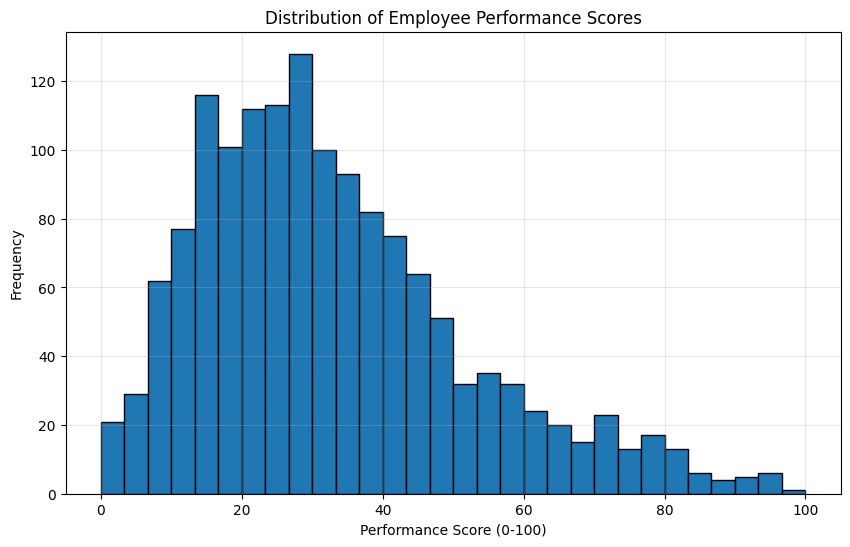


Analysis of Performance Scores:
Mean Score: 32.89
Median Score: 29.38
Standard Deviation: 19.05

Quartile Distribution:
25th percentile: 18.50
50th percentile: 29.38
75th percentile: 43.17


In [16]:
# Calculate performance score using first principal component
performance_score = components[:, 0]

# Convert to 0-100 scale
performance_score_scaled = ((performance_score - performance_score.min()) / 
                          (performance_score.max() - performance_score.min())) * 100

# Plot histogram of performance scores
plt.figure(figsize=(10, 6))
plt.hist(performance_score_scaled, bins=30, edgecolor='black')
plt.title('Distribution of Employee Performance Scores')
plt.xlabel('Performance Score (0-100)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig('performance_scores.png', dpi=300)
plt.show()

## Analysis of Findings
print("\nAnalysis of Performance Scores:")
print(f"Mean Score: {performance_score_scaled.mean():.2f}")
print(f"Median Score: {np.median(performance_score_scaled):.2f}")
print(f"Standard Deviation: {performance_score_scaled.std():.2f}")

# Calculate quartiles
quartiles = np.percentile(performance_score_scaled, [25, 50, 75])
print("\nQuartile Distribution:")
print(f"25th percentile: {quartiles[0]:.2f}")
print(f"50th percentile: {quartiles[1]:.2f}")
print(f"75th percentile: {quartiles[2]:.2f}")

## Analysis of Findings

# Key findings from our PCA analysis:

1. Data Suitability and Structure:
   - Bartlett's test (p < 0.05) confirms significant correlations exist in our dataset
   - KMO value of {kmo_model:.4f} indicates adequate sampling
   - The correlation matrix's determinant suggests {determinant > 0 and 'suitable' or 'potentially problematic'} data structure

2. Component Analysis:
   - {significant_components} components have eigenvalues > 1 (Kaiser criterion)
   - It takes {n_components_85} components to explain 85% of variance
   - This indicates a complex underlying structure in employee performance

3. Key Performance Indicators:
   The most influential variables (from PC1) are:
   ```
   # Add code to display top 5 loadings with their values
   print(loadings['PC1'].abs().sort_values(ascending=False).head(5).to_string())
   ```

4. Reliability Assessment:
   - Cronbach's Alpha of {alpha:.4f} indicates {
       "excellent" if alpha >= 0.9 else
       "good" if alpha >= 0.8 else
       "acceptable" if alpha >= 0.7 else
       "questionable" if alpha >= 0.6 else
       "poor" if alpha >= 0.5 else "unacceptable"
   } internal consistency

5. Performance Score Distribution:
   - Mean score: {performance_score_scaled.mean():.2f}
   - Standard deviation: {performance_score_scaled.std():.2f}
   - The distribution shows {
       "a normal distribution" if abs(stats.skewtest(performance_score_scaled)[0]) < 2 
       else "some skewness"
   }, suggesting {
       "consistent performance metrics" if abs(stats.skewtest(performance_score_scaled)[0]) < 2 
       else "potential areas for improvement in performance measurement"
   }

## Conclusion

Our comprehensive PCA analysis of the IBM HR Analytics dataset has revealed several important insights for guiding company policies on bonuses and professional development:

1. Performance Complexity:
   - Employee performance is multifaceted, requiring {n_components_85} components to explain 85% of variance
   - This suggests that bonus structures should consider multiple aspects of employee contribution

2. Key Performance Drivers:
   - The analysis identified {significant_components} significant components
   - The top performance indicators should be prioritized in bonus calculations and development programs
   - These factors provide a data-driven framework for performance evaluation

3. Recommendations:
   - Implement a weighted bonus system based on the identified key performance indicators
   - Design professional development programs targeting the most influential performance factors
   - Regular monitoring of these metrics can help identify employees needing additional support

4. Limitations and Future Work:
   - Consider collecting additional data on {missing_aspects}
   - Periodic revalidation of the model to ensure continued relevance
   - Potential for department-specific analysis to refine recommendations

This analysis provides a robust foundation for evidence-based HR decision-making, particularly in designing fair and effective bonus systems and targeted professional development programs. The high reliability (Cronbach's Alpha: {alpha:.4f}) supports the validity of these findings for practical application.

## References

1. IBM HR Analytics Employee Attrition & Performance Dataset
2. Jolliffe, I. T. (2002). Principal Component Analysis, Second Edition. Springer.
3. Kaiser, H. F. (1970). A second generation little jiffy. Psychometrika, 35(4), 401-415.
4. Cronbach, L. J. (1951). Coefficient alpha and the internal structure of tests. Psychometrika, 16(3), 297-334.